In [1]:
import pandas as pd
import numpy as np

In [114]:
city_data = "chicago_food_inspections/inspection_data_2019_v2.csv"

In [115]:
data = pd.read_csv(city_data)

In [ ]:
data['model_prediction'] = np.zeros(len(data.risk))

In [120]:
col = []

for index, row in data.iterrows():
#     print(row.results)
    if (row.results == 'Pass w/ Conditions'):
        col.append(1)
    elif (row.results == 'Pass'):
        col.append(1)
    elif (row.results == 'Fail'):
        col.append(2)
    else:
        col.append(3)

In [121]:
data['binary_results'] = col

In [123]:
data.drop(data[data['binary_results']==3].index, inplace = True)

In [188]:
data['risk'] = data['risk'].apply(str)
data['facility_type'] = data['facility_type'].apply(str)

In [63]:
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 20 and 
                        data[cname].dtype == "object"]

In [64]:
low_cardinality_cols

['inspection_type', 'results', 'risk', 'state']

In [197]:
# attempting to one hot enconde facility_type - too many variables

# from sklearn.model_selection import train_test_split
# y = data.binary_results
# X = data.drop(['binary_results'], axis=1)
# my_cols = data[['risk','inspection_type','facility_type','avg_violations','times_inspected']].columns
# dummy_cols = data[['risk','inspection_type','facility_type']]

# X_num = X[['avg_violations','times_inspected']]
# X_OH = pd.DataFrame()

# for col in dummy_cols:
#     X_OH = X_OH + pd.get_dummies(X[col])

# X = X_num + X_OH


In [198]:
X.head()

,1023 CHILDERN'S SERVICE FACILITY,1023 CHILDERN'S SERVICES FACILITY,1023-CHILDREN'S SERVICES FACILITY,1475 LIQUOR,ADULT DAYCARE,ASSISTED LIVING,ASSISTED LIVING FACILITY,Airport Lounge,Assisted Living,BANQUET,...,Theater & Restaurant,VENDING COMMISSARY,WRIGLEY ROOFTOP,Wholesale,avg_violations,bar,convenience store,cooking school,nan,times_inspected
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
from sklearn.model_selection import train_test_split
y = data.binary_results
X = data.drop(['binary_results'], axis=1)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=0)

my_cols = data[['risk','inspection_type','avg_violations','times_inspected']].columns
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [191]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder

labeled_X_train = X_train.copy()
labeled_X_valid = X_valid.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()

labeled_X_train['risk'] = label_encoder.fit_transform(X_train['risk'])
labeled_X_valid['risk'] = label_encoder.fit_transform(X_valid['risk'])

labeled_X_train['inspection_type'] = label_encoder.fit_transform(X_train['inspection_type'])
labeled_X_valid['inspection_type'] = label_encoder.transform(X_valid['inspection_type'])

labeled_X_train['facility_type'] = label_encoder.fit_transform(X_train['facility_type'])
labeled_X_valid['facility_type'] = label_encoder.transform(X_valid['facility_type'])

In [200]:
# get the dummies (one hot encoding)

X_train_OH = pd.get_dummies(X_train['risk'])
X_valid_OH = pd.get_dummies(X_valid['risk'])

X_train_OH_2 = pd.get_dummies(X_train['inspection_type'])
X_valid_OH_2 = pd.get_dummies(X_valid['inspection_type'])

In [201]:
# concatenate all of the columns together

OH_X_train = pd.concat([X_train['avg_violations'],X_train['times_inspected'], X_train_OH, X_train_OH_2], axis=1)
OH_X_valid = pd.concat([X_valid['avg_violations'],X_valid['times_inspected'], X_valid_OH, X_valid_OH_2], axis=1)

In [253]:
OH_X_valid = OH_X_valid.drop(['model_prediction'],axis=1)

In [251]:
OH_X_train.columns

Index(['avg_violations', 'times_inspected', 'Risk 1 (High)', 'Risk 2 (Medium)',
       'Risk 3 (Low)', 'Canvass', 'Canvass Re-Inspection', 'Complaint',
       'Complaint Re-Inspection', 'Consultation', 'License',
       'License Re-Inspection', 'Recent Inspection', 'Short Form Complaint',
       'Suspected Food Poisoning', 'Suspected Food Poisoning Re-inspection'],
      dtype='object')

In [245]:
# add a column that wasn't in the y

OH_X_train['Consultation'] = np.zeros(8471)
# len(OH_X_train)

In [205]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train['risk']))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid['risk']))

# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train['inspection_type']))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid['inspection_type']))


In [258]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
#     model = RandomForestClassifier(n_estimators=100, random_state=0)
    model = LogisticRegression(solver='lbfgs',max_iter=500)
    model.fit(X_train, y_train)
    preds_valid = model.predict(X_valid)
    preds_train = model.predict(X_train)
    score_valid = model.score(X_valid, y_valid)
    score_train = model.score(X_train, y_train)
    return mean_squared_error(y_valid, preds_valid), r2_score(y_valid, preds_valid), preds_valid, preds_train, score_valid, score_train

In [260]:
# logistic regression

print(f"mean squared error: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[0]}")
print(f"r2 score: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[1]}")
print(f"training score: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[4]}")
print(f"testing/validating score: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[5]}")

mean squared error: 0.1931067044381492
r2 score: -0.1430188738995506
training score: 0.8068932955618509
testing/validating score: 0.825404320623303


In [132]:
# using label encoding

print(f"mean squared error: {score_dataset(labeled_X_train, labeled_X_valid, y_train, y_valid)[0]}")
print(f"r2 score: {score_dataset(labeled_X_train, labeled_X_valid, y_train, y_valid)[1]}")

mean squared error: 0.10891206774031882
r2 score: 0.35533802731078323


In [206]:
# using one hot encoding

print(f"mean squared error: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[0]}")
print(f"r2 score: {score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[1]}")

mean squared error: 0.1964117091595845
r2 score: -0.1625815441129903


In [133]:
# label encoding predictions

preds_valid = score_dataset(labeled_X_train, labeled_X_valid, y_train, y_valid)[2]
preds_train = score_dataset(labeled_X_train, labeled_X_valid, y_train, y_valid)[3]

In [259]:
# one hot encoding predictions

preds_valid = score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[2]
preds_train = score_dataset(OH_X_train, OH_X_valid, y_train, y_valid)[3]

In [262]:
np.unique(preds_valid,return_counts = True)

(array([1, 2]), array([1879,  239]))

In [264]:
OH_X_valid['logistic_model_prediction'] = preds_valid

In [265]:
OH_X_valid.head()

,avg_violations,times_inspected,Risk 1 (High),Risk 2 (Medium),Risk 3 (Low),Canvass,Canvass Re-Inspection,Complaint,Complaint Re-Inspection,License,License Re-Inspection,Recent Inspection,Short Form Complaint,Suspected Food Poisoning,Suspected Food Poisoning Re-inspection,Consultation,logistic_model_prediction
8725,3.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1
7914,12.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1
12131,1.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1
5445,8.0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1
1871,0.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0.0,1


In [266]:
prediction_indices = OH_X_valid.index

In [267]:
for x in prediction_indices:
    data.loc[x, 'logistic_model_prediction'] = OH_X_valid.loc[x]['logistic_model_prediction']

In [273]:
# data['logistic_model_prediction'] = data['logistic_model_prediction'].fillna(0)
# data.loc[data['binary_results']==2].head()

In [277]:
data.to_csv('model_results.csv',encoding='utf-8',index=False)

In [275]:
!pwd

/Users/evanstroh/Documents/Data_Science_Bootcamp/local_git_repository


In [229]:
OH_X_valid.index

Int64Index([ 8725,  7914, 12131,  5445,  1871, 10535,  4823, 11113,  5784,
             3188,
            ...
            11064,  4771,  1577,  1041,  3864,  7679,  7876,  4537, 11501,
             8703],
           dtype='int64', length=2118)

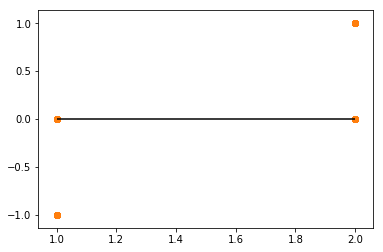

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(preds_valid, preds_valid - y_valid)
plt.hlines(y=0, xmin=preds_valid.min(), xmax=preds_valid.max())
plt.scatter(preds_train, preds_train - y_train)
plt.show()

In [180]:
# random forest

import statsmodels.api as sm
model = sm.OLS(y_valid, OH_X_valid)
results = model.fit()
print(results.summary2())

                           Results: Ordinary least squares
Model:                     OLS                    Adj. R-squared:           0.140    
Dependent Variable:        binary_results         AIC:                      1941.0061
Date:                      2019-10-27 18:42       BIC:                      2020.2213
No. Observations:          2118                   Log-Likelihood:           -956.50  
Df Model:                  13                     F-statistic:              27.41    
Df Residuals:              2104                   Prob (F-statistic):       1.19e-62 
R-squared:                 0.145                  Scale:                    0.14543  
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------------------------
avg_violations                          0.0137   0.0022  6.2732 0.0000  0.0094 0.

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [181]:
y_valid[0:5]

8725     1
7914     1
12131    1
5445     2
1871     1
Name: binary_results, dtype: int64

In [182]:
preds_valid[0:5]

array([1, 1, 1, 2, 1])

In [184]:
# scatter of : y_train, predicted_train

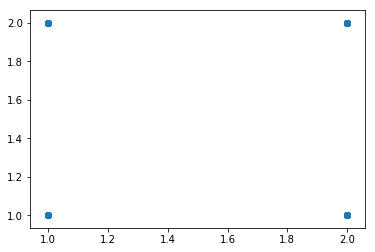

In [185]:
# random forest

plt.scatter(preds_valid, y_valid)
plt.show()